In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd
import tensorflow as tf

from keras import backend as K
from keras.layers import Dense
from keras.models import Model, Sequential

from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.graph.heterogeneous_network import HeterogeneousNetwork
from moge.visualization.plot_data import matrix_heatmap

from sklearn.metrics import pairwise_distances
np.set_printoptions(precision=2, suppress=True)

Using TensorFlow backend.


#  Import network from file

In [2]:
import pickle

# READ
with open('moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/LMN_mirtarbase_biogrid_starbase_lncrna2target_lncrinter.train.pickle', 'rb') as file:
# with open('moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_network_biogrid.pickle', 'rb') as file:
    network = pickle.load(file)
#     network.node_list.extend(network_test.node_list)
#     network.process_genes_info()
#     network.remove_extra_nodes()
#     network.node_list = network.all_nodes
#     node_list = network.node_list

with open('moge/data/LMN_future_recall/TEST/Interactions_Affinity/LMN_mirtarbase_biogrid_starbase_lncrna2target_lncrinter.test.pickle', 'rb') as file:
    network_test = pickle.load(file)
    network_test.process_genes_info()

Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'Chromosome', 'GO Terms', 'Family']
Number of nodes without seq removed: -10093
Total nodes (filtered): 22648


# Data Generator

In [3]:
from moge.graph.data_generator import DataGenerator

generator = DataGenerator(network=network, negative_sampling_ratio=2.0,
                          maxlen=1400, padding='post', truncating="post",
                          batch_size=1, sequence_to_matrix=False, 
                          shuffle=True, seed=0)
generator.genes_info = generator.genes_info[generator.genes_info["Transcript sequence"].notna()]

X, y = generator.__getitem__(0)
print("X:", [(k, v.shape) for k, v in X.items()], "\ny:", y.shape)

Ed_count: 376094 , Eu_count: 347505 , En_count: 1612996
Ens_count: 752188
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5} defaultdict(<class 'int'>, {1: 32494, 3: 32530, 5: 1604, 4: 32499, 2: 30916})
X: [('input_seq_j', (1, 1400)), ('input_seq_i', (1, 1400)), ('is_directed', (1, 1))] 
y: (1, 1)


# Load saved model to Siamese Graph Embedding

In [8]:
from moge.embedding.siamese_graph_embedding import SiameseGraphEmbedding
siamese = SiameseGraphEmbedding(d=128, batch_size=1, lr=0.001, epochs=20, negative_sampling_ratio=5.0,
                                 max_length=1400, truncating="post", verbose=True)
siamese.load_model(siamese_weights="moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/Models/siamese_128.randtrunc.multi.full.l1_bce.e20.weights.h5",
                   alpha_weights="moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/Models/alpha_128.randtrunc.multi.full.l1_bce.e20.weights.h5",
                   generator=generator)

Embedding Tensor("embedding_1/embedding_lookup/Identity:0", shape=(?, ?, 5), dtype=float32, device=/device:GPU:0)
conv2D Tensor("lambda_2/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:GPU:0)
max pooling_1 Tensor("max_pooling1d_1/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:GPU:0)
conv1d_2 Tensor("conv1d_1/Relu:0", shape=(?, ?, 320), dtype=float32, device=/device:GPU:0)
max pooling_2 Tensor("max_pooling1d_2/Squeeze:0", shape=(?, ?, 320), dtype=float32, device=/device:GPU:0)
brnn Tensor("bidirectional_1/concat_2:0", shape=(?, 640), dtype=float32, device=/device:GPU:0)
embedding Tensor("dense_3/BiasAdd:0", shape=(?, 128), dtype=float32, device=/device:GPU:0)
abs_diff_directed: Tensor("lambda_3/Abs:0", shape=(?, 64), dtype=float32, device=/device:GPU:0)
abs_diff_undirected: Tensor("lambda_4/Abs:0", shape=(?, 128), dtype=float32, device=/device:GPU:0)
alpha_directed: Tensor("alpha_directed/Sigmoid:0", shape=(?, 1), dtype=float32, device=/device:GPU:0)
alpha_un

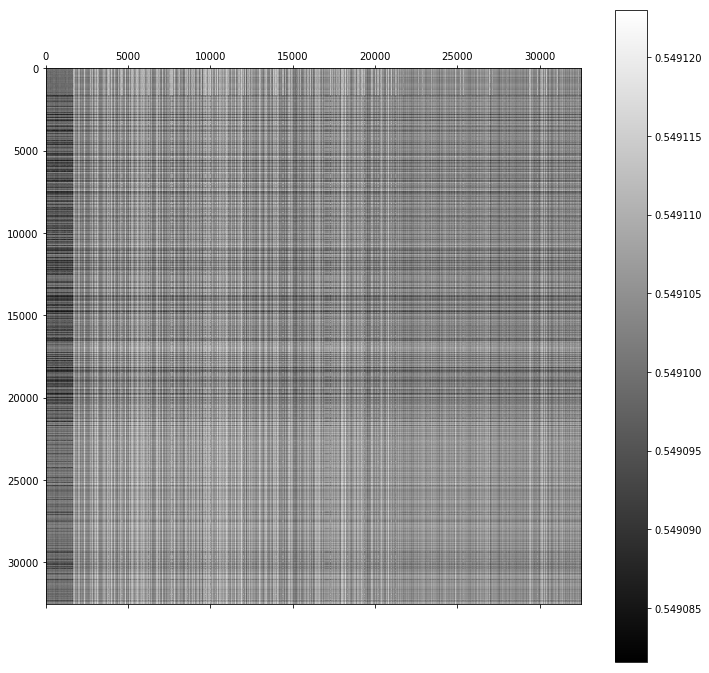

In [12]:
# siamese.save_embeddings("moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.siamese_multi_varlen.emb", 
#                         variable_length=True, minlen=100)
matrix_heatmap(siamese.get_reconstructed_adj())

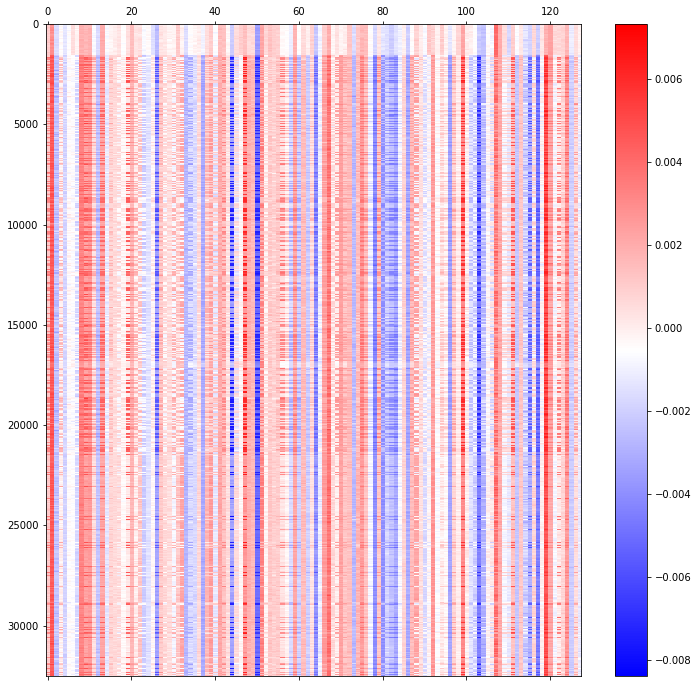

In [14]:
matrix_heatmap(siamese.get_embedding(), cmap="bwr", aspect="auto")

# Import Pre-Trained Embeddings

In [49]:
from moge.embedding.static_graph_embedding import ImportedGraphEmbedding

node2vec_emb = ImportedGraphEmbedding(d=128, method_name="node2vec")
node2vec_emb.import_embedding("moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.node2vec.emb", 
                          node_list=network.node_list)

line_emb = ImportedGraphEmbedding(d=128, method_name="LINE")
line_emb.import_embedding("moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.line.emb", 
                          node_list=network.node_list)

hope_emb = ImportedGraphEmbedding(d=128, method_name="HOPE")
hope_emb.import_embedding("moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.hope.emb", 
                          node_list=network.node_list)

sdne_emb = ImportedGraphEmbedding(d=128, method_name="SDNE")
sdne_emb.import_embedding("moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.sdne.emb", 
                          node_list=network.node_list)

rna2rna_emb = ImportedGraphEmbedding(d=128, method_name="rna2rna")
rna2rna_emb.import_embedding("moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.siamese_multi_interactions.emb", 
                         node_list=network.node_list)

rna2rna_l1_emb = ImportedGraphEmbedding(d=128, method_name="rna2rna")
rna2rna_l1_emb.import_embedding("moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.siamese.multi_seq.full.l1_bce.sampled.emb", 
                         node_list=network.node_list)
print()

node2vec imported (21329, 128)
LINE imported (21329, 128)
HOPE imported (21329, 128)
SDNE imported (21329, 128)
rna2rna imported (32528, 128)
rna2rna imported (32528, 128)



In [7]:
MIR = network.multi_omics_data["MIR"].get_genes_info()
MIR

,miR family,Seed+m8,Mature sequence,Family Conservation?,MiRBase Accession,MiRBase ID,location,ensembl_gene_id,Disease association,locus_type,Transcript sequence,Transcript length,Chromosome,Chromosome arm,Chromosome region,Chromosome band,GO Terms,Rfams,Family
MiRBase ID,,,,,,,,,,,,,,,,,,,
hsa-let-7a-1,NaN,NaN,NaN,NaN,NaN,hsa-let-7a-1,9q22.32,ENSG00000199165,colonic neoplasms|heart failure|lung neoplasms...,microRNA,TGGGATGAGGTAGTAGGTTGTATAGTTTTAGGGTCACACCCACCAC...,80.0,chr9,q,22,32,GO:0035068|GO:0035195,Rfam:RF00027,NaN
hsa-let-7a-2,let-7a-2-3p/let-7g-3p,UGUACAG,CUGUACAGCCUCCUAGCUUUCC,-1.0,MIMAT0010195,hsa-let-7a-2,11q24.1,ENSG00000198975,breast neoplasms|colonic neoplasms|heart failu...,microRNA,AGGTTGAGGTAGTAGGTTGTATAGTTTAGAATTACATCAAGGGAGA...,72.0,chr11,q,24,1,NaN,NaN,let-7a-2-3p/let-7g-3p
hsa-let-7a-3,NaN,NaN,NaN,NaN,NaN,hsa-let-7a-3,22q13.31,ENSG00000283990,breast neoplasms|colonic neoplasms|lung neopla...,microRNA,GGGTGAGGTAGTAGGTTGTATAGTTTGGGGCTCTGCCCTGCTATGG...,74.0,chr22,q,13,31,GO:0035068|GO:0035195,Rfam:RF00027,NaN
hsa-let-7b,let-7-5p/98-5p,GAGGUAG,UGAGGUAGUAGGUUGUGUGGUU,2.0,MIMAT0000063,hsa-let-7b,22q13.31,ENSG00000284520,colonic neoplasms|heart failure|lung neoplasms...,microRNA,CGGGGTGAGGTAGTAGGTTGTGTGGTTTCAGGGCAGTGATGTTGCC...,83.0,chr22,q,13,31,NaN,NaN,let-7-5p/98-5p
hsa-let-7c,let-7-5p/98-5p,GAGGUAG,UGAGGUAGUAGGUUGUAUGGUU,2.0,MIMAT0000064,hsa-let-7c,21q21.1,ENSG00000199030,colonic neoplasms|heart failure|lung neoplasms...,microRNA,GCATCCGGGTTGAGGTAGTAGGTTGTATGGTTTAGAGTTACACCCT...,84.0,chr21,q,21,1,NaN,NaN,let-7-5p/98-5p
hsa-let-7d,let-7-5p/98-5p,GAGGUAG,AGAGGUAGUAGGUUGCAUAGUU,2.0,MIMAT0000065,hsa-let-7d,9q22.32,ENSG00000199133,breast neoplasms|colonic neoplasms|heart failu...,microRNA,CCTAGGAAGAGGTAGTAGGTTGCATAGTTTTAGGGCAGGGATTTTG...,87.0,chr9,q,22,32,NaN,NaN,let-7-5p/98-5p
hsa-let-7e,let-7-5p/98-5p,GAGGUAG,UGAGGUAGGAGGUUGUAUAGUU,2.0,MIMAT0000066,hsa-let-7e,19q13.41,ENSG00000198972,"carcinoma, hepatocellular|colonic neoplasms|he...",microRNA,CCCGGGCTGAGGTAGGAGGTTGTATAGTTGAGGAGGACACCCAAGG...,79.0,chr19,q,13,41,NaN,NaN,let-7-5p/98-5p
hsa-let-7f-1,let-7a-3p/let-7b-3p/let-7f-1-3p/98-3p,UAUACAA,CUAUACAAUCUAUUGCCUUCCC,-1.0,MIMAT0004486,hsa-let-7f-1,9q22.32,ENSG00000199072,colonic neoplasms|heart failure|lung neoplasms...,microRNA,TCAGAGTGAGGTAGTAGATTGTATAGTTGTGGGGTAGTGATTTTAC...,87.0,chr9,q,22,32,NaN,NaN,let-7a-3p/let-7b-3p/let-7f-1-3p/98-3p
hsa-let-7f-2,let-7f-2-3p/1185-3p,UAUACAG,CUAUACAGUCUACUGUCUUUCC,-1.0,MIMAT0004487,hsa-let-7f-2,Xp11.22,ENSG00000208012,breast neoplasms|colonic neoplasms|heart failu...,microRNA,TGTGGGATGAGGTAGTAGATTGTATAGTTTTAGGGTCATACCCCAT...,83.0,chrX,p,11,22,NaN,NaN,let-7f-2-3p/1185-3p


In [24]:
MIR.loc["hsa-mir-106a","Transcript sequence"]

'CCTTGGCCATGTAAAAGTGCTTACAGTGCAGGTAGCTTTTTGAGATCTACTGCAATGTAAGCACTTCTTACATTACCATGG'

In [34]:
with open("moge/data/SequenceFiles/miRNA_hairpin.fa", "w") as file:
    for miRNA in MIR.index:
        if MIR.loc[miRNA,"Transcript sequence"] is not None:
            file.write(">{}\n".format(miRNA))
            file.write("{}\n".format(MIR.loc[miRNA,"Transcript sequence"]))
    file.close()

In [1]:
from moge.embedding.sequence_based_embedding import BioVecEmbedding, iDeepVEmbedding, LncTarInteraction

# biovec_emb = BioVecEmbedding(network, {"MIR": "./moge/data/biovec/miRNA_protvec.model",
#                          "GE": "./moge/data/biovec/mRNA_protvec.model",
#                          "LNC": "./moge/data/biovec/lncRNA_protvec.model"})

lncTar_interactions = LncTarInteraction(table_file="moge/data/LncTar/lncRNA-mRNA.txt")

node_list size 1186


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/embedding/sequence_based_embedding.py:47: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  self.table = pd.read_table(table_file)


In [39]:
biovec_emb.save_embeddings(file_path="moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.biovec.emb")

Saved at moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.biovec.emb


In [38]:
from gensim.models import Word2Vec
model = Word2Vec.load("./moge/data/iDeepV/miRNA_RNA2Vec.model")

TypeError: save_embeddings() missing 1 required positional argument: 'file_path'

In [50]:
# Select method
methods = {}
methods["node2vec"] = node2vec_emb
methods["LINE"] = line_emb
methods["HOPE"] = hope_emb
methods["SDNE"] = sdne_emb
methods["BioVec"] = biovec_emb
# methods["LncTar"] = lncTar_interactions
methods["rna2rna"] = rna2rna_emb
methods["rna2rna_l1"] = rna2rna_l1_emb

# Top-K Link Prediction

In [34]:
from moge.evaluation.link_prediction import evaluate_top_k_link_pred

for method in list(methods.keys()) + ['LncTar']:
    print(method)
    print(evaluate_top_k_link_pred(methods[method], network_train=network, network_test=network_test, 
                         node_list=methods[method].node_list, edge_type="d", top_k=10000))

node2vec
{'precision': 0.0, 'recall': 0.0}
LINE
{'precision': 0.0, 'recall': 0.0}
HOPE
{'precision': 0.0033, 'recall': 0.0004776309504855915}
SDNE
{'precision': 0.0, 'recall': 0.0}
BioVec
{'precision': 0.0, 'recall': 0.0}
LncTar
{'precision': 0.00010980564401010212, 'recall': 0.11764705882352941}
rna2rna
{'precision': 0.0, 'recall': 0.0}
rna2rna*
{'precision': 0.0, 'recall': 0.0}


# Scale-free fit score

In [39]:
for method in methods.keys():
    print("\n", method)
    for A, B in [("MIR", "LNC"), ("LNC", "MIR"), ("LNC", "GE"), ("MIR", "GE"), ("GE", "GE")]:
        print(A, B, methods[method].get_scalefree_fit_score(network.nodes[A], network.nodes[B]))


 node2vec


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/embedding/static_graph_embedding.py:277: RuntimeWarning: divide by zero encountered in log10
  node_set = set(self.node_list)


MIR LNC 0.08834114711570744
LNC MIR 0.28016987812509936
LNC GE 0.011028217139735612
MIR GE 0.14033404261415514
GE GE 0.015659846720439324

 LINE
MIR LNC 0.7448612710696526
LNC MIR 0.7448612710696512
LNC GE 0.5556534990520942
MIR GE 0.8113404992049733
GE GE 0.5166360744989273

 HOPE


AssertionError: 

In [52]:
for method in ["HOPE", "SDNE", "rna2rna", "rna2rna_l1"]:
    print("\n", method)
    for A, B in [("MIR", "LNC"), ("LNC", "MIR"), ("LNC", "GE"), ("MIR", "GE"), ("GE", "GE")]:
        print(A, B, methods[method].get_scalefree_fit_score(network.nodes[A], network.nodes[B]))


 HOPE


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/embedding/static_graph_embedding.py:278: RuntimeWarning: divide by zero encountered in log10
  d = np.log10(cosine_adj_hist_dist.pdf(np.power(adj_list, k_power)))


MIR LNC 0.3794218405909367
LNC MIR 0.37942184059093537
LNC GE 0.587080848807502


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/embedding/static_graph_embedding.py:277: RuntimeWarning: divide by zero encountered in log10
  c = np.log10(np.power(adj_list, k_power))


MIR GE 0.6712858690553146
GE GE 0.760586083568203

 SDNE
MIR LNC 7.118068818660377e-31
LNC MIR 3.0931629289571864e-32
LNC GE 0.009668907469202832
MIR GE 2.6878427264648255e-05
GE GE 0.0012593207054826421

 rna2rna
MIR LNC 0.09869227445111252
LNC MIR 0.06294569948348733
LNC GE 0.12417059889524378
MIR GE 0.2347868478647411
GE GE 0.01235831243415167

 rna2rna_l1
MIR LNC 0.0001174568148073759
LNC MIR 3.0501692220147113e-05
LNC GE 7.419685659995039e-05
MIR GE 0.00012133631050232886
GE GE 0.00017660066421556738


# Clustering Result

In [53]:
from moge.evaluation.node_clustering import evaluate_clustering

for method in methods.keys():
    print(method)
    print(evaluate_clustering(methods[method], network=network, node_label="Family", 
                              max_clusters=500, n_clusters=None))

node2vec
Clustering 13652 nodes with n_clusters: 500
{'homogeneity': 0.5424490040451104, 'completeness': 0.5878097520143878, 'nmi': 0.5642191451094991}
LINE
Clustering 13652 nodes with n_clusters: 500
{'homogeneity': 0.5443922099767258, 'completeness': 0.5821280772991128, 'nmi': 0.5626281107759029}
HOPE
Clustering 13652 nodes with n_clusters: 500
{'homogeneity': 0.39805936853780777, 'completeness': 0.5104521280195128, 'nmi': 0.44730364451784926}
SDNE
Clustering 13652 nodes with n_clusters: 500
{'homogeneity': 0.3924461267267583, 'completeness': 0.48856016836954386, 'nmi': 0.43526033086663046}
BioVec
Clustering 14311 nodes with n_clusters: 500
{'homogeneity': 0.37659813097558725, 'completeness': 0.4678957469765395, 'nmi': 0.41731187970264977}
rna2rna
Clustering 14312 nodes with n_clusters: 500
{'homogeneity': 0.4948506793000231, 'completeness': 0.5684797732581655, 'nmi': 0.5291160453240795}
rna2rna_l1
Clustering 14312 nodes with n_clusters: 500
{'homogeneity': 0.3125119573721486, 'compl

# Node Classification

In [54]:
from moge.evaluation.node_classification import evaluate_classification

for method in methods.keys():
    print()
    print(method)
    print([(k, np.average(v)) for k,v in evaluate_classification(methods[method], network, cv=5,
                                  node_label="Family", multilabel=False,
                                  scoring=['precision_macro', 'recall_macro', "f1_macro"],
                                                                verbose=True).items()])


node2vec
# of labels with >cv samples: 567 , # of nodes to train/test: 10929


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 33.070201826095584), ('score_time', 0.12344579696655274), ('test_precision_macro', 0.1315789571292397), ('test_recall_macro', 0.17777665523947772), ('test_f1_macro', 0.1421067811073222)]

LINE
# of labels with >cv samples: 567 , # of nodes to train/test: 10929


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 55.06734685897827), ('score_time', 0.1043278694152832), ('test_precision_macro', 0.12972974095992842), ('test_recall_macro', 0.15180911943826184), ('test_f1_macro', 0.1326998009007978)]

HOPE
# of labels with >cv samples: 567 , # of nodes to train/test: 10929


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 234.9034550189972), ('score_time', 0.0798807144165039), ('test_precision_macro', 0.06458845294192495), ('test_recall_macro', 0.07889896448145262), ('test_f1_macro', 0.06583291110858902)]

SDNE
# of labels with >cv samples: 567 , # of nodes to train/test: 10929


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 208.5308316230774), ('score_time', 0.07240900993347169), ('test_precision_macro', 0.0015209638143644747), ('test_recall_macro', 0.0043052341921142), ('test_f1_macro', 0.0012849387061570055)]

BioVec
# of labels with >cv samples: 567 , # of nodes to train/test: 11504


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 87.06694874763488), ('score_time', 0.07640814781188965), ('test_precision_macro', 0.014778436565653141), ('test_recall_macro', 0.020553627072052882), ('test_f1_macro', 0.014432693394128771)]

rna2rna
# of labels with >cv samples: 567 , # of nodes to train/test: 11504


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 54.840038251876834), ('score_time', 0.11641874313354492), ('test_precision_macro', 0.009652282058331657), ('test_recall_macro', 0.020318037351496905), ('test_f1_macro', 0.0113717210642828)]

rna2rna_l1
# of labels with >cv samples: 567 , # of nodes to train/test: 11504


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[('fit_time', 655.7422921180726), ('score_time', 0.11902918815612792), ('test_precision_macro', 0.014758020637959895), ('test_recall_macro', 0.012817142397542345), ('test_f1_macro', 0.011016267670930132)]


# Visualize embedding

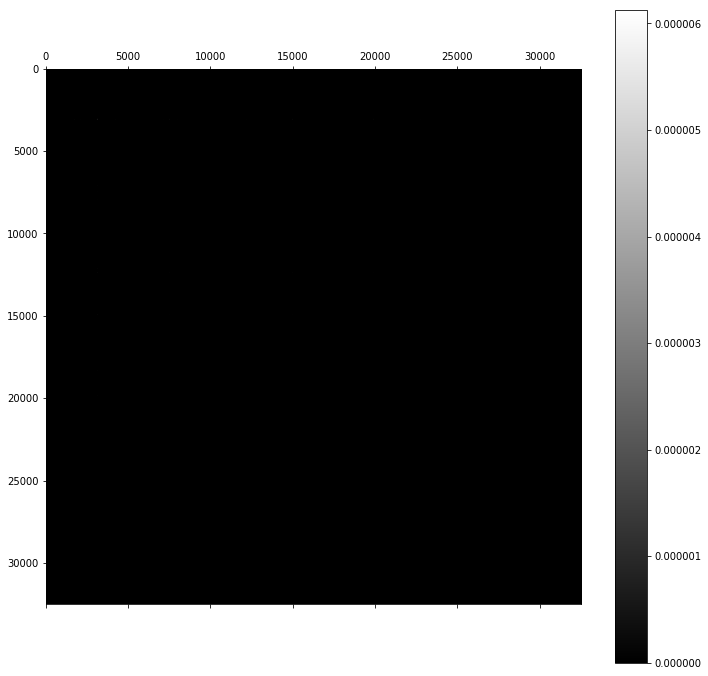

In [56]:
matrix_heatmap(rna2rna_l1_emb.get_reconstructed_adj())

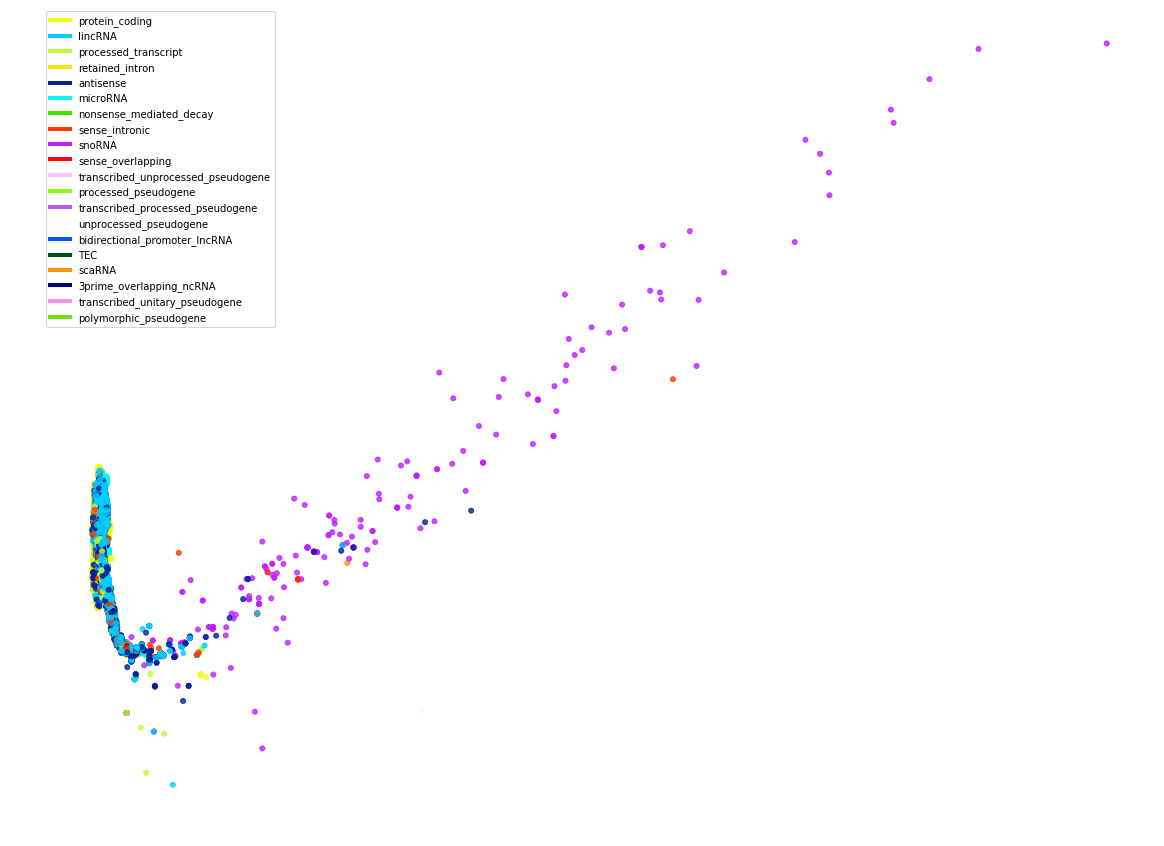

In [55]:
from moge.visualization.visualize_embedding import visualize_embedding
visualize_embedding(rna2rna_l1_emb, network=network, node_label="locus_type", 
                    edgelist=network_test.get_edgelist(node_list=network_test.nodes, edge_types=["d"]),
#                     test_nodes=node_list,
                    cmap="gist_ncar",)

# Visualize Embeddings & Adjacency Matrix

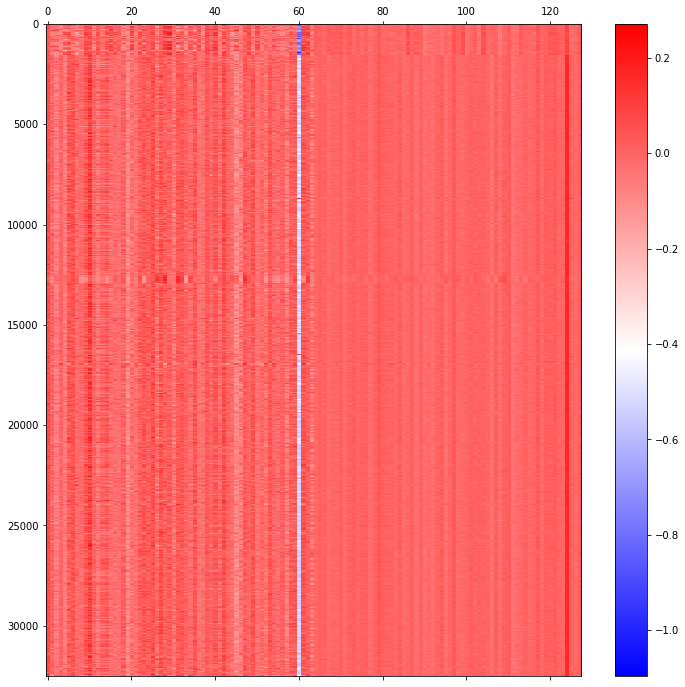

In [15]:
matrix_heatmap(siamese.get_embedding(), cmap="bwr", aspect='auto')

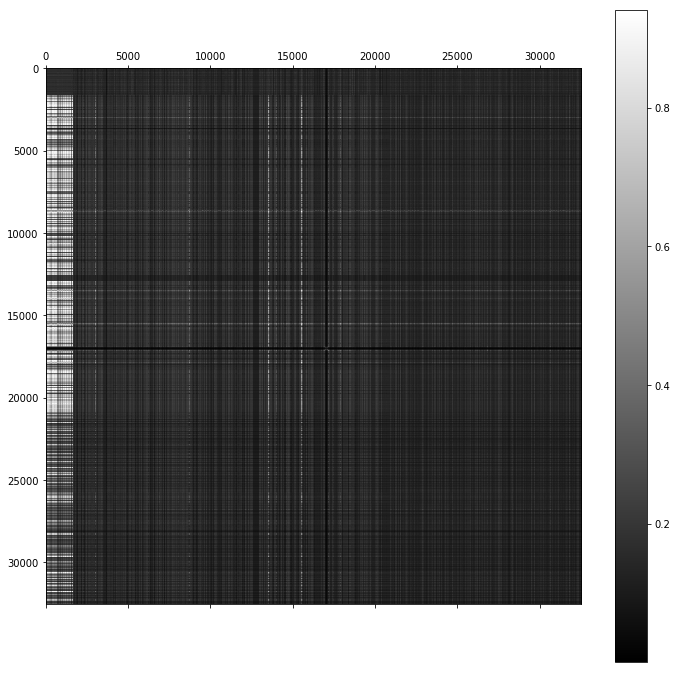

In [20]:
matrix_heatmap(rna2rna_emb.get_reconstructed_adj(edge_type="u", node_l=rna2rna_emb.node_list))

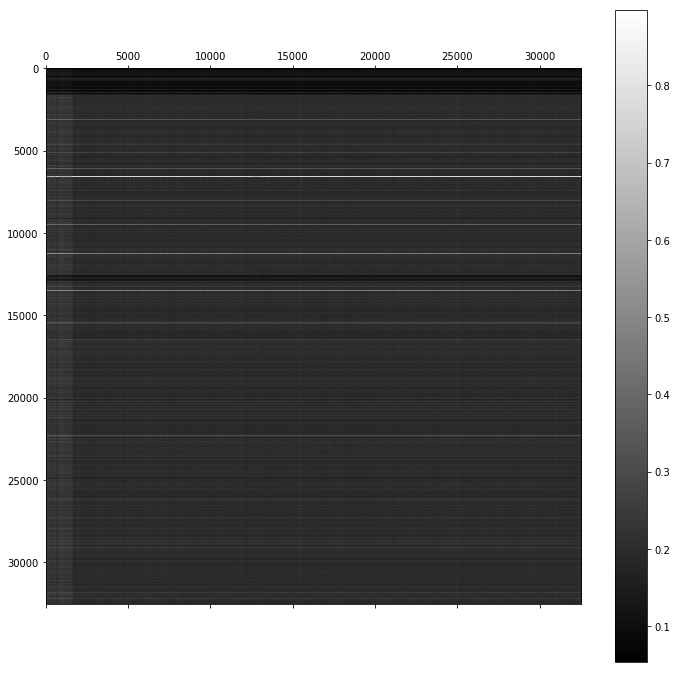

In [22]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="d", node_l=generator.node_list, beta=2.0))

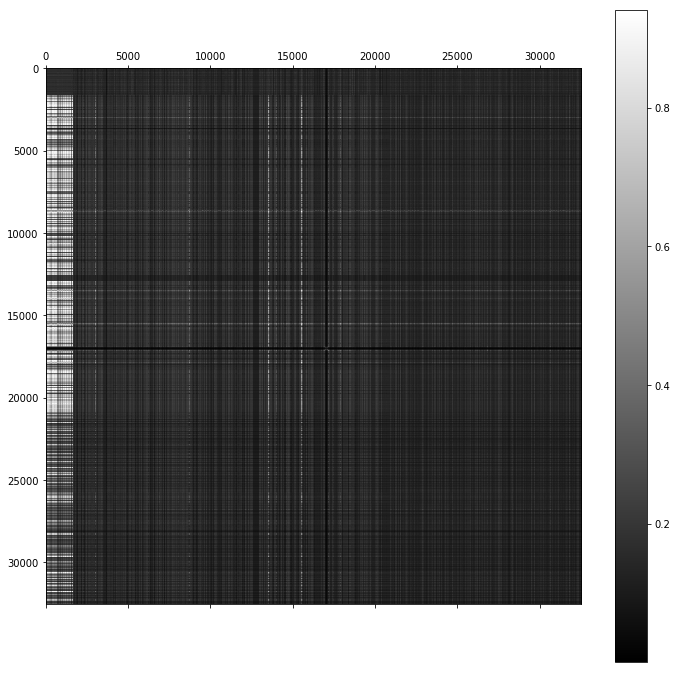

In [24]:
matrix_heatmap(rna2rna_emb.get_reconstructed_adj(edge_type="d", node_l=generator.node_list))

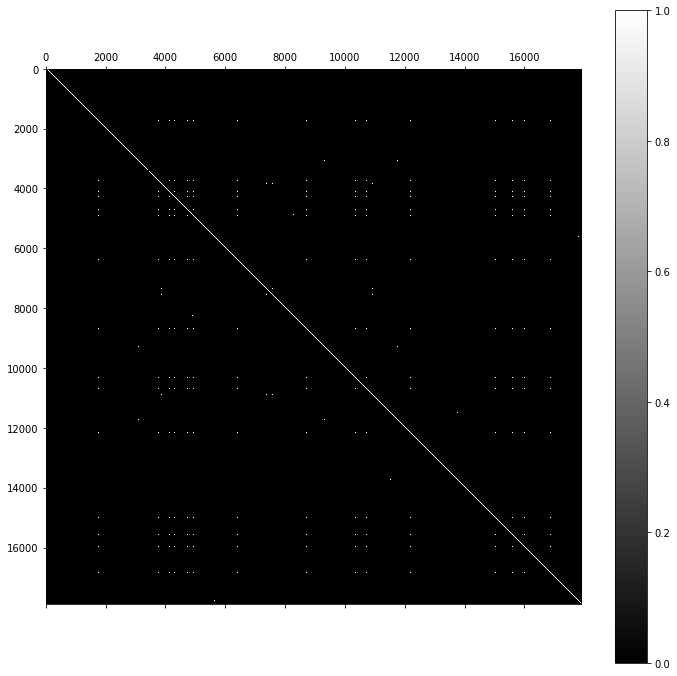

In [31]:
method = sdne_emb
matrix_heatmap(method.get_reconstructed_adj(node_l=method.node_list))

# Get top-k predicted edges for lung cancer associated lncRNAs

In [11]:
LNC = network.multi_omics_data.LNC.get_genes_info()

In [12]:
lung_lncRNAs = LNC[LNC["Disease association"].notnull() & LNC["Disease association"].str.contains("lung")].index.tolist()

In [13]:
lung_lncRNAs_nodes = list(set([v for u,v in network.G.edges(lung_lncRNAs)] + [u for u,v in network.G.edges(lung_lncRNAs)]))
lung_lncRNAs_nodes

['DCAF12',
 'DCLRE1A',
 'MIR4489',
 'PARD3-AS1',
 'BYSL',
 'LRRN1',
 'S100B',
 'MRGPRG',
 'THAP11',
 'SYN2',
 'NUP93',
 'RN7SKP266',
 'FERMT3',
 'HIST1H2BH',
 'VASH1',
 'DLX3',
 'GAPDHP25',
 'PDE6G',
 'PROZ',
 'COPS5',
 'RN7SL753P',
 'KRT1',
 'AMD1',
 'C15orf54',
 'hsa-mir-877',
 'AKR1C7P',
 'FKBP9P1',
 'HIST1H2AG',
 'RAB6C',
 'hsa-mir-4725',
 'KANSL1',
 'PSMC1P9',
 'VEGF',
 'PHF2',
 'CENPQ',
 'UNC93B3',
 'LOC728392',
 'PDK1',
 'MRFAP1',
 'LRRC23',
 'ZNF574',
 'hsa-mir-144',
 'CLIP2',
 'LINC01914',
 'hsa-mir-1234',
 'VTA1',
 'EP300',
 'CTPS1',
 'ZNF134',
 'BMP7-AS1',
 'ENSG00000272003',
 'FRRS1L',
 'RHAG',
 'SPOCD1',
 'UQCRC1',
 'SLTM',
 'AC011471.2',
 'NAPSB',
 'SALL2',
 'CYB5R3',
 'ATAD3A',
 'FAM47A',
 'RPL7P11',
 'ELL2',
 'HBP1',
 'TFAMP2',
 'FAM126A',
 'GPR180',
 'RNU6-832P',
 'IL6R',
 'SLC35G3',
 'LOC149373',
 'RPL35P1',
 'SHPK',
 'RNA5SP41',
 'EIF3F',
 'CHRNA5',
 'MLH3',
 'BGLT3',
 'JMJD4',
 'CD302',
 'OTUD7B',
 'SLC5A1',
 'SPHK1',
 'ZIK1',
 'AC062039.1',
 'HK3',
 'DGCR8',
 'KLK8

In [54]:
lung_lncRNAs_nodes = network.G.neighbors(lung_lncRNAs)

TypeError: unhashable type: 'list'

In [168]:
top_k_pred_edges = siamese.get_top_k_predicted_edges(edge_type="d", top_k=50, 
                                                     node_list=lung_lncRNAs_nodes,
                                                    remove_training_edges=True)

Embeddings filtered by node list (2015, 128)


In [169]:
top_k_pred_edges = [(u,v) for u,v,w in top_k_pred_edges if (u in siamese.node_list and v in siamese.node_list)]
len(top_k_pred_edges)

39

In [55]:
rna2rna_emb.predict_cluster()

array([3, 3, 3, ..., 7, 1, 5], dtype=int32)

# Gene Set Enrichment Analysis of Clusters

In [16]:
import gseapy as gp

In [18]:
names = gp.get_library_name()
names

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlex_2017',
 'CORUM',
 'Cancer_Cell_Line_Encyclopedia',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'Disease_Perturbations_from_GEO_down',
 'Disease_Perturbations_from_GEO_up',
 'Disease_Signatures_from_GEO_down_2014',
 'Disease_Signatures_from_GEO_up_2014',
 'DrugMatrix',
 'Drug_Perturbations_from_GEO_2014',
 'Drug_Perturbations_from_GEO_down',
 'Drug_Perturbations_from_GEO_up',
 'ENCODE_Histone_Modifications_2013',
 'ENCODE_Histone_Modifications_2015',
 'ENCODE_TF_ChIP-seq_2014',
 'ENCODE_TF_ChIP-seq_2015',
 'ENCODE_and_ChEA_Cons

In [52]:
enr = gp.enrichr(gene_list=lung_lncRNAs,
                 description='test_lung_nodes',
                 gene_sets=["KEGG_2018"],
#                  outdir='./enrichr_test_lung/',
                 no_plot=True,
                 cutoff=0.5 
                )
enr.results.sort_values(by="P-value").head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Z-score,Combined Score,Genes
0,KEGG_2018,Glycosyltransferases sce01003,1/63,0.137961,0.275922,0.017501,0.035001,-1.464341,2.900544,GAS5
1,KEGG_2018,Chromosome and associated proteins sce03036,1/324,0.536304,0.536304,0.088871,0.088871,-1.818814,1.133220,GAS5


# Visualize Embeddings

In [181]:
from sklearn.metrics.pairwise import pairwise_distances
from moge.visualization.plot_data import matrix_heatmap
from scipy import sparse
# from sklearn.manifold import TSNE
from moge.visualization.visualize_embedding import get_node_color, plot_embedding2D
import matplotlib.pyplot as plt

In [182]:
from sklearn.decomposition import PCA

embs_pca = PCA(n_components=2).fit_transform(embs)

In [183]:
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(init=embs_pca, perplexity=80, n_jobs=8, verbose=True)
node_pos = tsne.fit_transform(embs)

In [36]:
g = network.G.subgraph(generator.node_list)
# g = nx.relabel.relabel_nodes(g, {k: v for v, k in enumerate(generator.node_list)})

In [189]:
generator.genes_info["locus_type"]

A1BG                                 protein_coding
A1CF                                 protein_coding
A2M                            processed_transcript
A2ML1                       nonsense_mediated_decay
A4GALT                         processed_transcript
A4GNT                                protein_coding
AAAS                                retained_intron
AACS                           processed_transcript
AACSP1           transcribed_unprocessed_pseudogene
AADAC                                protein_coding
AADACL2                              protein_coding
AADACL3                              protein_coding
AADACL4                              protein_coding
AADAT                                protein_coding
AAGAB                          processed_transcript
AAK1                           processed_transcript
AAMDC                       nonsense_mediated_decay
AAMP                                retained_intron
AANAT                                protein_coding
AAR2        

In [184]:
nodelist = generator.genes_info[generator.genes_info["Transcript sequence"].notnull()][
    generator.genes_info["locus_type"].isin([\
                                             "RNA, micro", 
                                             "lincRNA", 
                                             "sense_intronic"
                                             "protein_coding"
                                            ])].index.tolist()
nodelist = method.node_list
# nodelist = lung_lncRNAs
# nodelist = network_test.node_list
nodelist = [node for node in nodelist if node in method.node_list]
len(nodelist)

19532

In [191]:
edgelist = [(u,v) for u, v, d in network_test.G.edges(data=True) if (d["type"]=="d" and (u in nodelist and v in nodelist))]
np.random.shuffle(edgelist)
len(edgelist)

525651

In [187]:
node_labels = generator.genes_info.loc[nodelist]["locus_type"].astype(str) # "Transcript length", "locus_type", "Family"
sorted_node_labels = sorted(node_labels.unique(), reverse=True)
node_colormap = {f:sorted_node_labels.index(f)/len(sorted_node_labels) for f in node_labels.unique()}
node_colors = [node_colormap[n] if n in node_colormap.keys() else None for n in node_labels]      

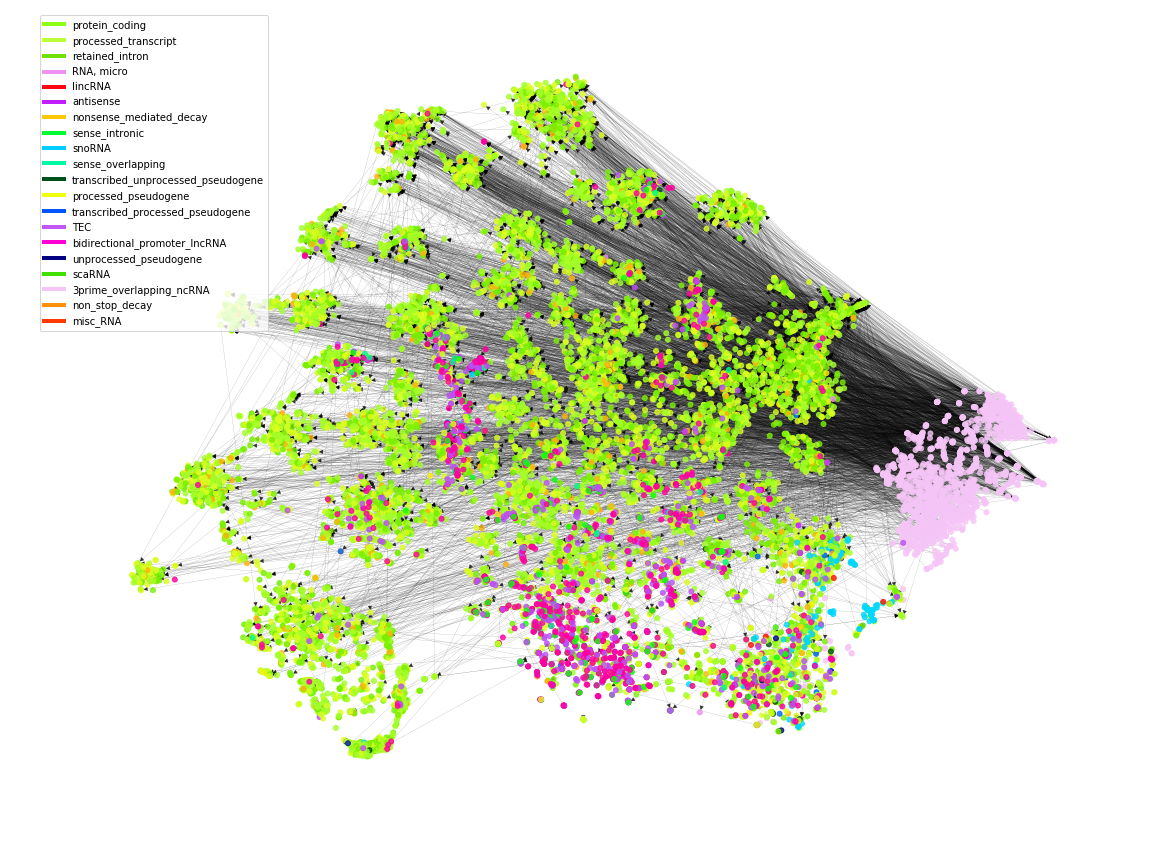

In [192]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

plot_embedding2D(method.get_node_pos(), node_list=method.node_list, node_colors=node_colors,
                 legend=True, node_labels=node_labels, node_colormap=node_colormap, legend_size=20,
                 di_graph=g, cmap="gist_ncar", nodelist=nodelist,
                 plot_nodes_only=False, edgelist=edgelist[0:5000], 
                 with_labels=False, figsize=(20,15),
#                  file_name="moge/data/LMN_only_directed/results/LMN_sne_viz_edges.pdf"
                )


In [59]:
plt.savefig("moge/data/LMN_only_directed/results/LMN_sne_viz_edges.pdf")

<Figure size 432x288 with 0 Axes>